# Q1 - Object candidacy with a non-neural network approach

We look the impact of stellar features on the score it is given by the Kepler data analysis project using a random forest classifier. The reasoning behind this is explored after the data normalization, which is the first step

**Before working through this notebook, ensure you have read through the [README.md](https://github.com/GHancock1/Coursework-2/blob/main/README.md) and installed the necessary Python dependencies.**

In [ ]:
# Initial setup for the notebook

# Importing required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import sys
sys.path.append("..")
from functions import *

# Importing the Kepler Exoplanet Search Results dataset from GitHub.
df = getData()

# We don't need to know the identity of every data type, so we will drop those columns.
df = df.drop(columns=["rowid","kepid", "kepoi_name", "kepler_name"])

Now that we have our data, we will want normalize it, which often helps machine learning algorithms. To normalize, we will use a technique called z-score normalization, or standardization. It transforms data into a normal distribution. The mathematics is as follows: 
$$
Z = \frac{X-\mu}{\sigma}
$$
Z is the z-score, X is the data point, $\mu$ is the mean, and $\sigma$ is the standard deviation.

In [3]:
scaled_df = normalize(df)
scaled_df.head()

,koi_disposition,koi_pdisposition,koi_score,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
0,CONFIRMED,CANDIDATE,1.088571,-0.316020,0.362554,0.937332,-0.130845,-0.299634
1,CONFIRMED,CANDIDATE,1.023572,-0.316020,0.362554,0.937332,-0.130845,-0.299634
2,CANDIDATE,CANDIDATE,-1.008179,0.183441,0.540545,-0.196975,-0.140474,-0.179444
3,FALSE POSITIVE,FALSE POSITIVE,-1.008179,0.123205,0.586777,-1.402176,-0.153041,-0.537152
4,CONFIRMED,CANDIDATE,1.088571,0.406819,0.295519,0.689202,-0.111423,0.204019


We should have a look at the data to see if we can see any relationships becoming apparent. To do so, we will use Seaborn's pairplot function, which plots a graph of each column of the dataset against every other, and makes a histogram for each column.

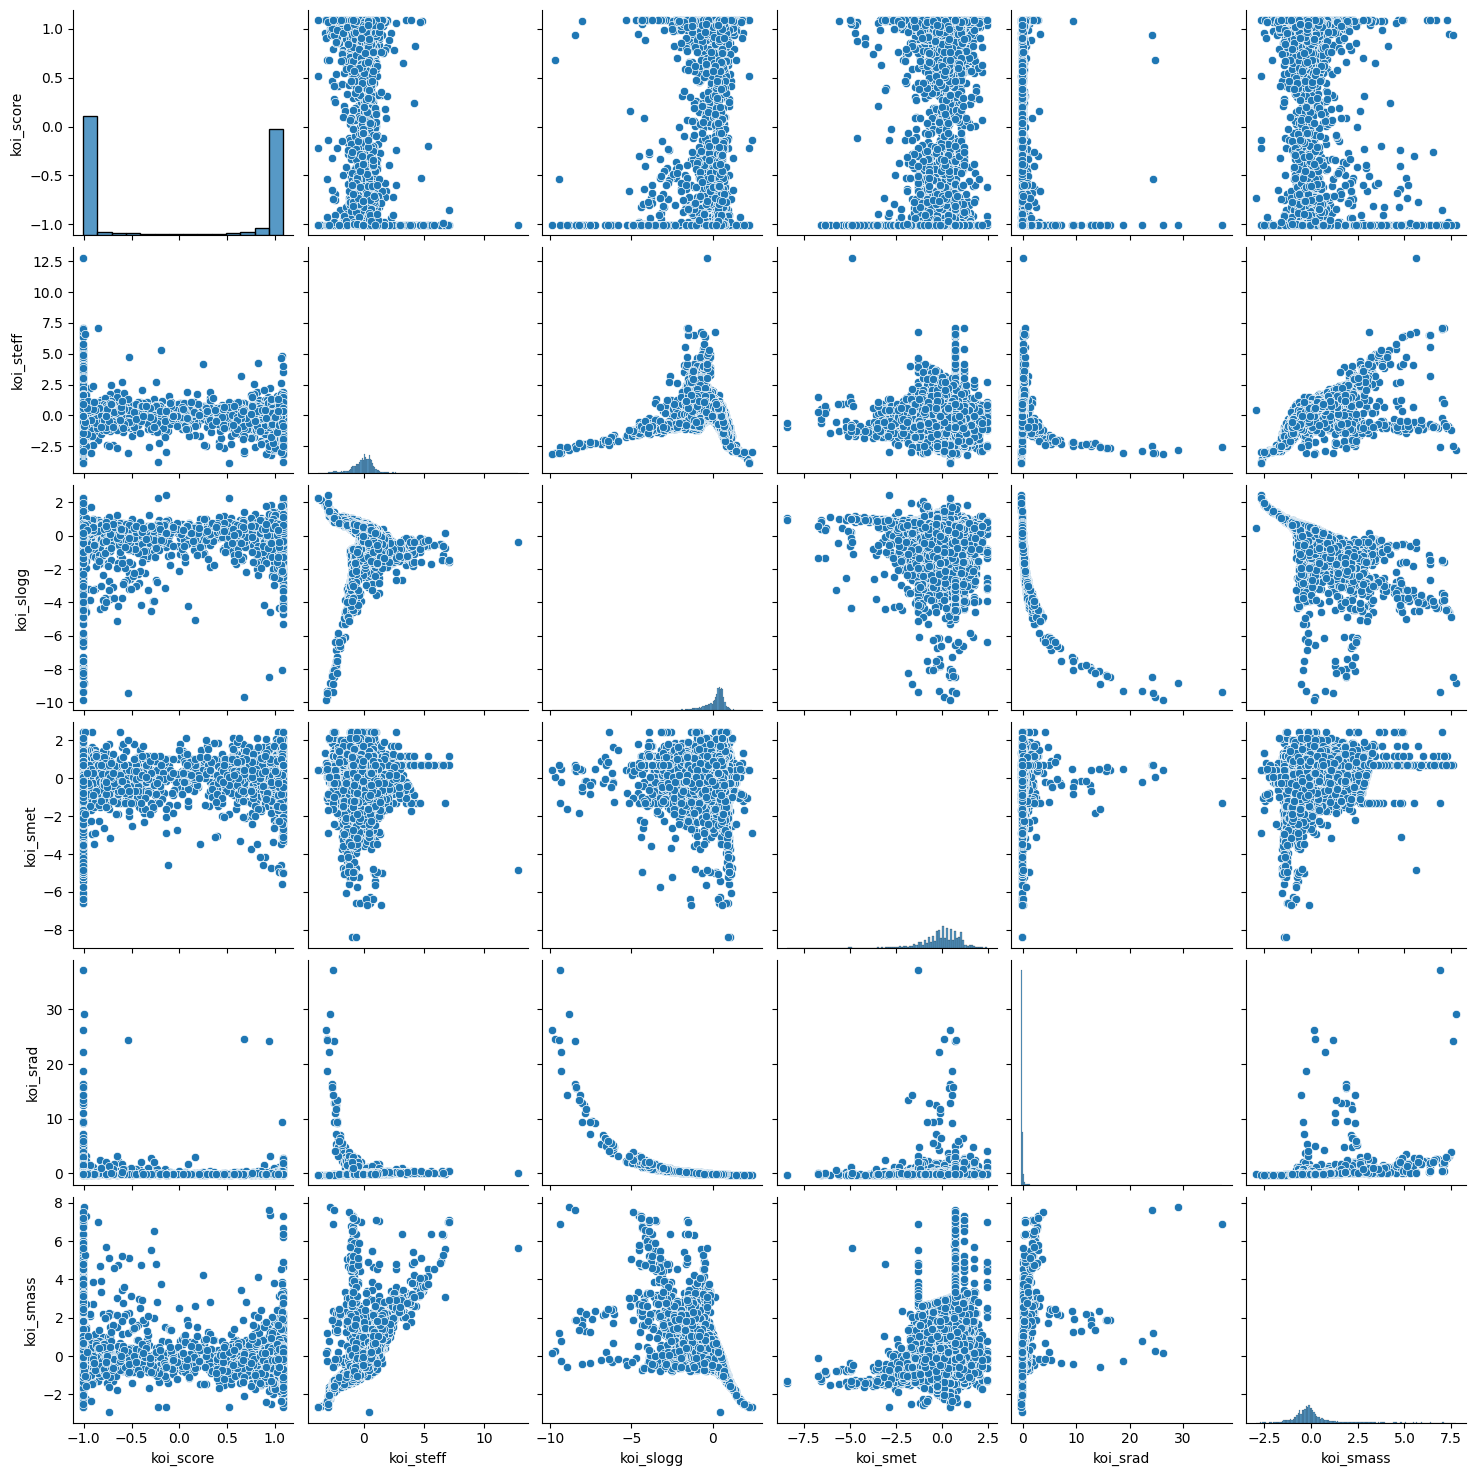

In [4]:
sns.pairplot(scaled_df)

These are the relationships in the normalized data. There are no relationships between koi_score and the stellar parameters that we can initially see by eye, which suggests a regression method might not be useful. Instead, we will use a classification method. There are many of these that we could use, but we will use a random forest. A random forest is good for avoiding overfitting (in which the divisions between classes are fit too perfectly to the training data, and test data that should be in one category are classed as another), which our relatively small dataset could be prone to. The data also has a lot of outliers, against which random forests are less susceptible.

In order for classification to work, we need to decide on what our categories will be. We choose categories to be `koi_score > 0.75` and `koi_score < 0.75`, to chop the data into 'probably an exoplanet' and 'probably not an exoplanet'. After normalization, 0.75 becomes  0.5, so we choose our categories to cut off at 0.5 after normalization.

The standard in machine learning is to have the features (columns) of the data labelled **X**, and the target (what you want to predict) labelled y:

In [ ]:
s_features = ["koi_steff", "koi_slogg", "koi_smet", "koi_srad", "koi_smass"]
model_df = scaled_df.dropna(subset=s_features + ["koi_score"]).copy()
X = model_df[s_features]
y = (model_df["koi_score"] >= 0.5).astype(int) 
X.head()

,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
0,-0.316020,0.362554,0.937332,-0.130845,-0.299634
1,-0.316020,0.362554,0.937332,-0.130845,-0.299634
2,0.183441,0.540545,-0.196975,-0.140474,-0.179444
3,0.123205,0.586777,-1.402176,-0.153041,-0.537152
4,0.406819,0.295519,0.689202,-0.111423,0.204019


In [75]:
# Splitting the dataset to training and testing data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

In [76]:
# Setting up the random forest classifier and fitting it to the trainign data.
rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_leaf=2, class_weight="balanced", random_state=1, n_jobs=-1) # random-state set to 1 for reproducibility
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",1000
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

The model has been trained on our training data, and so is ready to be tried out on the test data. We will then plot a confusion matrix, which shows the number of correct predictions (top left and bottom right) against the number of incorrect predictions (bottom left and top right). This confusion matrix will show us how well the model predicts the test data compared to the actual data. 

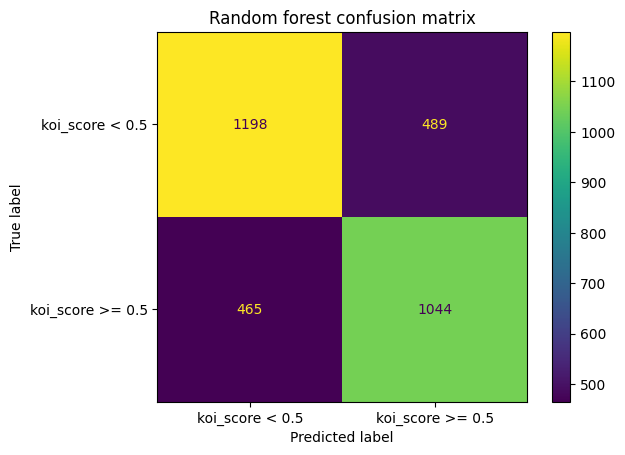

In [77]:
y_pred = rf.predict(X_test)
labels = ["koi_score < 0.5", "koi_score >= 0.5"] # 0.5 corresponds to a pre-normalized koi_score of 0.75
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels)
plt.title("Random forest confusion matrix")
plt.show()

We are looking to answer the question of whether or not a star's features have an impact on an object's candidacy, and what of those features are most important. The confusion matrix answers the first part - the model is able to predict the koi_score of objects with decent accuracy (~70%), showing that there must be some kind of impact. To answer the second part, we simply to look at the *feature importance* of each feature, which is provided within the random forest classifier as `feature_importances_`

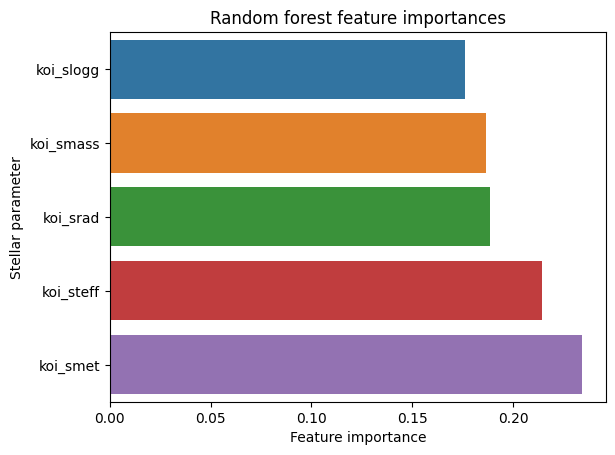

In [78]:
importances = pd.Series(rf.feature_importances_, index=s_features).sort_values()
plt.figure()
sns.barplot(x=importances.values, y=importances.index, hue=importances.index)
plt.xlabel("Feature importance")
plt.ylabel("Stellar parameter")
plt.title("Random forest feature importances")
plt.show()

# How well did a traditional method do?
We can see that the most important feature is the star's metallicity. This means that `koi_score` varies most with the metallicity of the star, which makes sense physically; a star that forms with a higher metal content means that there was mroe material to form into a planet in the protoplanetary disk. The least import features are the star's mass and surface gravity. These results also make sense, as the surface gravity of a star shouldn't greatly impact the formation of a planet around that star, and its mass should play only a small role. The stellar radius seems to be of almost equal importance to the stellar mass, which makes sense given that the two are closely related. The stellar temperature being in between mass and metallicity is sensible also, as a star's effective temperature is an interplay between those two features.
The fact that these all make sense, and that the confusion matrix shows an accuracy of ~70%, suggests that the random forest method works pretty well for determining an object's `koi_score` based on the features of it's star.